In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# 지금 터틀전략 시스템에 대해 이해를 하고있는가. 진입, 청산, 피라미딩의 세부 규칙이 추세추종 베팅철학에 부합하는가 이런 것들에 대한 이해를 했는가
import yfinance as yf
import pandas as pd
import requests

start = '2000-01-01'
end = '2024-07-01'

assets = 'nasdaq100'
benchmark = 'NQ=F'

ldf = pd.read_html(requests.get(f'https://www.slickcharts.com/{assets}', headers={'User-agent': 'Mozilla/5.0'}).text)
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]
downloads = yf.download([*symbols, benchmark], start, end, group_by='ticker')

data = downloads[symbols]
data
# data.set_index(data.DatetimeIndex(data["Date"]), inplace=True)
benchmark = downloads[benchmark]['Close']

[*********************100%%**********************]  102 of 102 completed


In [9]:
data2 = data.fillna(method='ffill', limit=1)

27.65523 sec
                    Benchmark    Strategy
------------------  -----------  ------------------------
Start Period        2000-01-03   2000-01-03
End Period          2024-06-28   2024-06-28
Risk-Free Rate      0.0%         0.0%
Time in Market      97.0%        98.0%

Cumulative Return   445.43%      -
CAGR﹪              4.9%         -3.74%

Sharpe              0.4          -0.16
Prob. Sharpe Ratio  97.59%       20.77%
Sortino             0.57         -0.23
Sortino/√2          0.4          -0.16
Omega               0.97         0.97

Max Drawdown        -78.99%      -
Longest DD Days     5031         8528

Gain/Pain Ratio     0.08         -0.03
Gain/Pain (1M)      0.43         -0.12

Payoff Ratio        0.93         0.94
Profit Factor       1.08         -
Common Sense Ratio  0.99         0.96
CPC Index           0.55         0.44
Tail Ratio          0.92         2.59
Outlier Win Ratio   40018.92     0.9
Outlier Loss Ratio  2.04         -

MTD                 7.19%        4.68

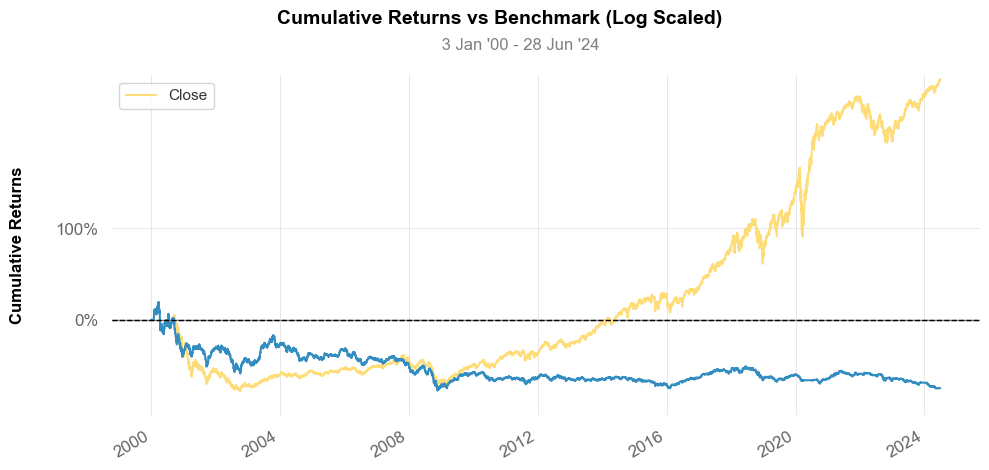

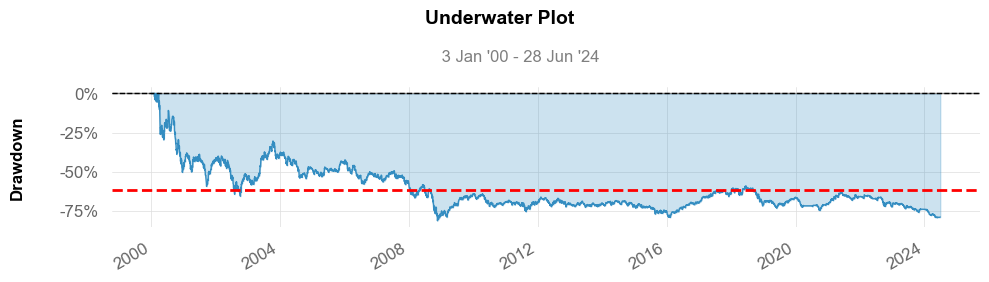

In [10]:
import sys
sys.path.append('/Users/dongin/Desktop/my-btester/myBtester')
from myBtester import Strategy, Backtest
# import talib #talib랑 판다스ewm 계산 방식이 다르다. 참고.. 그리고 데이터 중간에 결측값이 하나도 있으면 계산 못함.
import time
import pandas_ta as ta

start = time.time() #


class MACrossoverStrategy_RiskManagement_ATR(Strategy):

    def init(self, fast_period: int, slow_period: int):
        self.max_total_unit_risk = .01 # 거래당 1% 리스크 지는 것
        self.highpoint_of_account = 0 #초기 현금으로 최대 계좌 초기화
        self.account_pole = self.cash # 자산 최대값 기준로 리스크단위 증감 계산하기 위함 초기 계좌기준 10%씩 늘어나면 갱신하는 구조로할까

        self.fast_ma = {} #next에서 가격데이터랑 같은 날짜로 반복문이 돌려진다.
        self.slow_ma = {}
        self.atr = {}

        for symbol in self.symbols:
            self.fast_ma[symbol] = ta.ema(self.data[(symbol,'Close')], length=fast_period)
            self.slow_ma[symbol] = ta.ema(self.data[(symbol,'Close')], timeperiod=slow_period)
            self.atr[symbol] = ta.atr(self.data[(symbol,'High')], self.data[(symbol,'Low')], self.data[(symbol,'Close')], timeperiod=20)
                        


        
    def next(self, i, record): #지표까지 모두 준비된 데이터에 대해서 모두 동일한 시점에서 시작하는 부분이다. 35,285.57%
      # i는 이동하는 캔들이다. 계속 캔들을 갱신하는 것이다, 지표는 앞전에 init함수로 미리 데이터를 만들어 놓고, 이 부분에서 하나씩 갱신하는 것.
        self.riskSize()

        for symbol in self.symbols:
            open_condition1 = self.fast_ma[symbol][i-1] > self.slow_ma[symbol][i-1]
            if open_condition1 and self.atr[symbol][i]>0: #해당 종목에서 포지션이 있더라도 조전에 만족하면 그냥 진입함. 피라미딩같은 느낌
                position_size = self.positionSize(record[(symbol,'Open')], self.atr[symbol][i])
                stop_loss = record[(symbol,'Open')]-self.atr[symbol][i]
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=position_size, stopLoss=stop_loss)

        for position in self.open_positions[:]: # [:]리스트 맨 앞부터 맨 뒤까지 불러오는 슬라이싱, i가 돌면서 매 순간마다 포지션을 수시로 불러오는 것다. 그리고 조건이 되면 close를 하는 것이고
            # 매 순간마다 포지션을 모두 불러오고 해당 순간의 가격에 대해서 조건이 맞으면 close를 하는 로직인데.. 처음 진입 시점의 atr을 알아야된다고...
            close_condition1 = self.fast_ma[position.symbol][i-1] < self.slow_ma[position.symbol][i-1]
            stoploss_condition1 = position.stopLoss > record[(position.symbol,'Open')]
            if close_condition1 or stoploss_condition1: #atr만이 청산전략이 아니다. 다른 가격적인 조건이 청산 조건이 추가되어야함. 청산에서 atr은 정해진 리스크량으로 정의하기 위해서 사용된 것
                self.close(position=position, price=record[(position.symbol, 'Open')])


    def positionSize(self, price: float, atr: float):
        if pd.isna(self.cash) or pd.isna(self.assets_value) or pd.isna(self.max_total_unit_risk) or pd.isna(atr):return 0
        return round((self.cash+self.assets_value) * self.max_total_unit_risk / (2*atr)) if price > 0 else 0

    def riskSize(self):
        self.highpoint_of_account = max(self.highpoint_of_account, self.cash+self.assets_value)
        if self.highpoint_of_account > self.account_pole * 1.11: self.account_pole *= 1.11
        # self.account_pole = self.highpoint_of_account
        condition1 = self.cash+self.assets_value < self.account_pole * (1-0.11)
        condition2 = self.cash+self.assets_value < self.account_pole * (1-0.22)
        condition3 = self.cash+self.assets_value < self.account_pole * (1-0.33)
        condition1_2 = self.cash+self.assets_value > self.account_pole * (1-0.22)
        condition2_3 = self.cash+self.assets_value > self.account_pole * (1-0.33)
        condition3_4 = self.cash+self.assets_value > self.account_pole * (1-0.44)
        if condition1 and condition1_2: self.max_total_unit_risk = .01*0.8          *(0.8*0.8*0.8*0.8)
        if condition2 and condition2_3: self.max_total_unit_risk = .01*0.8*0.8      *(0.8*0.8*0.8*0.8)
        if condition3 and condition3_4: self.max_total_unit_risk = .01*0.8*0.8*0.8  *(0.8*0.8*0.8*0.8)
        if not condition1: self.max_total_unit_risk = .01 # 다시 자산이 정상화되면 리스크 단위도 정상화



from btester import Backtest #초기 자산이 얼마냐에따라 누적 수익이 달라져있음...음 아마 시작 부분이 추세가 없어서 진입할때 가격이 비싸 못사는 경우로 그냥 안사게되니 그럴수도
backtest = Backtest(MACrossoverStrategy_RiskManagement_ATR, data2, commission=.003, cash=1e3)
result = backtest.run(20, 60)
end = time.time()
print(f"{end - start:.5f} sec")


import quantstats as qs
qs.reports.metrics(result.returns, benchmark)
qs.plots.log_returns(result.returns, benchmark, fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')



In [2]:
!pip install quantstats

   ---------------------------------------- 0.0/45.5 kB ? eta -:--:--
   ----------------- ---------------------- 20.5/45.5 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 45.5/45.5 kB 1.1 MB/s eta 0:00:00


In [6]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value,long,takeProfit,stopLoss
0,META,2023-03-14,2024-06-28,187.580002,504.220001,59,18681.759964,168.802642,29748.980072,NaN,None,180.817217
1,AVGO,2023-10-30,2024-06-28,84.110001,160.552994,239,18269.875366,90.884547,38372.165512,NaN,None,81.600091
2,META,2023-10-30,2024-06-28,299.089996,504.220001,61,12512.930298,68.584709,30757.420074,NaN,None,289.236007
3,COST,2023-10-30,2024-06-28,545.739990,849.989990,65,19776.250000,55.749992,55249.349365,NaN,None,536.581979
4,TMUS,2023-10-30,2024-06-28,141.320007,176.179993,216,7529.756836,24.667410,38054.878418,NaN,None,138.545141
5,AVGO,2023-11-01,2024-06-28,84.199997,160.552994,249,19011.896210,90.680522,39977.695450,NaN,None,81.782228
6,META,2023-11-01,2024-06-28,301.850006,504.220001,62,12546.939697,67.043230,31261.640076,NaN,None,292.059330
7,META,2023-11-03,2024-06-28,312.549988,504.220001,65,12458.550873,61.324595,32774.300079,NaN,None,302.981627
8,NVDA,2024-05-03,2024-06-28,87.789001,123.540001,600,21450.599670,40.723780,74124.000549,NaN,None,83.931100
9,NVDA,2024-05-15,2024-06-28,92.472000,123.540001,687,21343.716545,33.597198,84871.980629,NaN,None,88.963905
